In [124]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
%matplotlib inline

import json
import numpy as np

from collections import Counter
from folium.plugins import MarkerCluster
from sklearn.cluster import DBSCAN

from utils import *
from FedRank import FedRank

In [2]:
# develop mode
%load_ext autoreload
%autoreload 2

In [3]:
# Moscow coordinates
MOW = [55.75222, 37.61556]

r = 0.02
r2 = r**2

In [4]:
# load mcc codes
mcc_codes = pd.read_csv('./data/mcc_codes.csv', index_col='mcc')

In [5]:
def clean_df(df):
    df.loc[:,'mcc'] = clean_mcc(train_df)
    df['pos_address'] = df.atm_address.fillna('')+df.pos_address.fillna('')
    df.drop(['atm_address'], axis=1, inplace=True)
    df['pos_address_lon'] = df.atm_address_lon.fillna(0)+df.pos_address_lon.fillna(0)
    df['pos_address_lat'] = df.atm_address_lat.fillna(0)+df.pos_address_lat.fillna(0)
    return df.drop(['atm_address_lon', 'atm_address_lat'], axis=1)

In [6]:
# load, clean and group train data
train_df = pd.read_csv('./data/train_set.csv')
train_df.rename(columns={'pos_adress_lat':'pos_address_lat', 'pos_adress_lon':'pos_address_lon'}, inplace= True)

train_df = clean_df(train_df)
train_df.loc[:,'mcc'] = clean_mcc(train_df)

train_gr = train_df.groupby('customer_id')
train_df.head()

C:\Anaconda3\work\raiffazen\env\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (1,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,amount,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_address_lat,pos_address_lon,terminal_id,transaction_date,work_add_lat,work_add_lon
0,2.884034,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,,59.844072,30.179153,11606fde0c814ce78e0d726e39a0a5ee,2017-07-15,59.847,30.177
1,2.775633,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,,59.844072,30.179153,e9647a5e1eacfb06713b6af755ccc595,2017-10-27,59.847,30.177
2,3.708368,St Petersburg,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5992,"PR.MARSHALA ZHUKOVA,31St Petersburg190000 7...",59.858198,30.229024,df06c1fcd3718a514535ae822785f716,2017-10-03,59.847,30.177
3,2.787498,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,,59.844072,30.179153,6c5e5793ebc984fb72875feffff62854,2017-09-09,59.847,30.177
4,2.892510,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,,59.844072,30.179153,0576445d74e374c92c0902e612fca356,2017-07-06,59.847,30.177


In [7]:
test_df = pd.read_csv('./data/test_set.csv')
test_df.loc[:,'mcc'] = clean_mcc(test_df)
test_df = clean_df(test_df)
test_gr = test_df.groupby('customer_id')

C:\Anaconda3\work\raiffazen\env\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (1,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
mcc_code = 5411

In [9]:
# test DBSCAN
core_samples_mask = np.zeros_like(dbs.labels_, dtype=bool)
core_samples_mask[dbs.core_sample_indices_] = True


unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = position[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = position[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

#plt.title('Estimated number of clusters: %d' % n_clusters_)
#plt.show()

NameError: name 'dbs' is not defined

In [11]:
def dbscan_clust(position, home_pos = np.nan, dbscan_params = {'leaf_size':5, 'eps': 0.02, 'n_jobs': 5}):
    dbs = DBSCAN(**dbscan_params)
    dbs.fit(position)
    labels = dbs.labels_

    clust_size = 0
    best_clust = [0, 0]
    clust_size = np.NAN
    d = np.Inf
    
    for label in set(labels):
        if label<0:
            continue
        clust = position[labels == label]

        if clust_size < clust.shape[0]:
            best_clust = np.mean(clust, axis = 0)
            clust_size = clust.shape[0]
            print(best_clust)
            d = haversine(best_clust, home_pos)
            
    return best_clust, clust_size, d

In [12]:
dbscan_params = {'leaf_size':5, 'eps': 0.02, 'n_jobs': 5, 'min_samples': 2}
r = 0.02
r2 = r**2

def get_dbscan_score(df, dbscan_params, mcc_code = 5411, calc_dist = True):
    score = 0
    res = {}
        
    for user_id, data in df:
        test_set = data.query('mcc == @mcc_code')
        position = test_set.loc[:,['pos_address_lat', 'pos_address_lon']].dropna().as_matrix()

        if calc_dist:
            home_pos = test_set.loc[:,['home_add_lat','home_add_lon']].dropna().as_matrix()
            if (len(home_pos) ==0):
                continue
            home_pos = np.unique(home_pos, axis=0)[0]
            if len(np.unique(home_pos, axis=0)) >2:
                raise ValueError('Wrong home position. Check it!!!')
        else:
            home_pos = np.array([90, 90])
        
        clust_size = -1
        d = np.Inf
        best_clust = np.array([90, 90])
        clust_amount = -1
        
        if len(position) >1:
            
            dbs = DBSCAN(**dbscan_params)
            dbs.fit(position)
            labels = dbs.labels_
            clust_amount = len(set(labels))

            for label in set(labels):
                if label<0:
                    continue
                clust = position[labels == label]
                if clust_size < clust.shape[0]:
                    best_clust = np.mean(clust, axis = 0)
                    clust_size = clust.shape[0]
                    if calc_dist:
                        d = haversine(best_clust, home_pos)
                    else:
                        d = np.inf
                    
        res.update({user_id: [best_clust[0], best_clust[1], home_pos[0], home_pos[1], d, clust_size, clust_amount]})
        
    res_df = pd.DataFrame.from_dict(res,  orient='index')
    res_df.columns = ['pr_home_lat', 'pr_home_lon',  'real_home_lat', 'real_home_lon', 'dist', 'clust_size', 'clust_amount']
        
    return res_df

In [13]:
best_dbscan_params = {'eps': 0.036, 'min_samples': 2}

In [14]:
dbscan_params = {'leaf_size':5, 'eps': 0.02, 'n_jobs': 5, 'min_samples': 2}


def get_dbscan_clust(df, dbscan_params, mcc_code = 5411):
    score = 0
    res = pd.DataFrame(columns=['clust_label'])
    for user_id, user_data in df:
        test_set = user_data.query('mcc == @mcc_code')
        position = test_set.loc[:,['pos_address_lat', 'pos_address_lon']].dropna()      
        if len(position) >0:
            
            dbs = DBSCAN(**dbscan_params)
            dbs.fit(position)
            res = res.append(pd.DataFrame(dbs.labels_, index=position.index, columns= ['clust_label']))
        
    return res

In [15]:
clust_5411 = get_dbscan_clust(train_gr, best_dbscan_params)

In [16]:
train_df = train_df.merge(clust_5411, left_index=True, right_index=True, how='left')
train_df.clust_label.fillna(-2, inplace=True)
t_gr = train_df.groupby(['customer_id','clust_label'])

In [23]:
t_gr.aggregate('count').head(9)

amount  city  country  currency  \
customer_id                      clust_label                                    
0001f322716470bf9bfc1708f06f00fc -2               83    83       83        83   
                                  0                7     7        7         7   
                                  1                3     3        3         3   
                                  2                7     7        7         7   
0007297d86e14bd68bd87b1dbdefe302 -2              182   182      182       182   
                                  0               40    40       40        40   
                                  1                3     3        3         3   
                                  2                3     3        3         3   
                                  3               19    19       19        19   

                                              home_add_lat  home_add_lon  mcc  \
customer_id                      clust_label                                    
0001f322716470bf9bfc1708f06f00fc -2                     83            83   83   
                                  0                      7             7    7   
                                  1                      3             3    3   
                                  2                      7             7    7   
0007297d86e14bd68bd87b1dbdefe302 -2                    182           182  182   
                                  0                     40            40   40   
                                  1                      3             3    3   
                                  2                      3             3    3   
                                  3                     19            19   19   

                                              pos_address  pos_address_lat  \
customer_id                      clust_label                                 
0001f322716470bf9bfc1708f06f00fc -2                    83               83   
                                  0                     7                7   
                                  1                     3                3   
                                  2                     7                7   
0007297d86e14bd68bd87b1dbdefe302 -2                   182              182   
                                  0                    40               40   
                                  1                     3                3   
                                  2                     3                3   
                                  3                    19               19   

                                              pos_address_lon  terminal_id  \
customer_id                      clust_label                                 
0001f322716470bf9bfc1708f06f00fc -2                        83           83   
                                  0                         7            7   
                                  1                         3            3   
                                  2                         7            7   
0007297d86e14bd68bd87b1dbdefe302 -2                       182          182   
                                  0                        40           40   
                                  1                         3            3   
                                  2                         3            3   
                                  3                        19           19   

                                              transaction_date  work_add_lat  \
customer_id                      clust_label                                   
0001f322716470bf9bfc1708f06f00fc -2                         83            83   
                                  0                          7             7   
                                  1                          3             3   
                                  2                          7             7   
0007297d86e14bd68bd87b1dbdefe302 -2                        182  

In [24]:
agg_dict = {
    'pos_address_lat':np.mean,
    'pos_address_lon': np.mean,
    'amount': [np.mean, np.max, np.min, 'count', 'std']
}

agg_dict.update({'home_add_lat': np.mean, 'home_add_lon': np.mean})

c = t_gr.aggregate(agg_dict)
newidx = []
for (n1,n2) in c.columns.ravel():
    newidx.append("%s_%s" % (n1,n2))
c.columns=newidx
c.head(10)

pos_address_lat_mean  \
customer_id                      clust_label                         
0001f322716470bf9bfc1708f06f00fc -2                      17.785491   
                                  0                      56.251347   
                                  1                      44.744977   
                                  2                      44.711199   
0007297d86e14bd68bd87b1dbdefe302 -2                      53.649054   
                                  0                      55.800632   
                                  1                      55.822604   
                                  2                      55.670268   
                                  3                      55.747618   
000b709c6c6fb1e8efcfd95e57c2a9de -2                      53.443488   

                                              pos_address_lon_mean  \
customer_id                      clust_label                         
0001f322716470bf9bfc1708f06f00fc -2                      15.020104   
                                  0                      43.446254   
                                  1                      37.725649   
                                  2                      37.846624   
0007297d86e14bd68bd87b1dbdefe302 -2                      35.916029   
                                  0                      37.400692   
                                  1                      37.524894   
                                  2                      37.481117   
                                  3                      37.537587   
000b709c6c6fb1e8efcfd95e57c2a9de -2                      73.031566   

                                              amount_mean  amount_amax  \
customer_id                      clust_label                             
0001f322716470bf9bfc1708f06f00fc -2              3.343322     4.614833   
                                  0              2.553616     2.973381   
                                  1              3.016776     3.460175   
                                  2              2.203973     2.394246   
0007297d86e14bd68bd87b1dbdefe302 -2              2.859040     4.696914   
                                  0              2.834341     3.596210   
                                  1              2.820427     3.401110   
                                  2              1.830931     2.290534   
                                  3              2.425873     3.211002   
000b709c6c6fb1e8efcfd95e57c2a9de -2              2.949456     4.319009   

                                              amount_amin  amount_count  \
customer_id                      clust_label                              
0001f322716470bf9bfc1708f06f00fc -2              1.982628            83   
                                  0              2.347082             7   
                                  1              2.407830             3   
                                  2              1.949756             7   
0007297d86e14bd68bd87b1dbdefe302 -2              0.706783           182   
                                  0              0.816582            40   
                                  1              2.359619             3   
                                  2              1.483227             3   
                                  3              1.936728            19   
000b709c6c6fb1e8efcfd95e57c2a9de -2              1.730401            32   

                                              amount_std  home_add_lat_mean  \
customer_id                      clust_label                                  
0001f322716470bf9bfc1708f06f00fc -2             0.761167             44.708   
                                  0             0.233241             44.708   
                                  1             0.545355             44.708   
                                  2             0.160099             44.708   
0007297d86e14bd68bd87b1dbdefe302 -2             0.733852             55.799   
                     

In [25]:
c = c.assign(dist_home_sq =  (c.pos_address_lat_mean-c.home_add_lat_mean)**2+(c.pos_address_lon_mean-c.home_add_lon_mean)**2)
c= c.assign(is_home = (c.dist_home_sq<r2).astype(int))
c.head(10)

pos_address_lat_mean  \
customer_id                      clust_label                         
0001f322716470bf9bfc1708f06f00fc -2                      17.785491   
                                  0                      56.251347   
                                  1                      44.744977   
                                  2                      44.711199   
0007297d86e14bd68bd87b1dbdefe302 -2                      53.649054   
                                  0                      55.800632   
                                  1                      55.822604   
                                  2                      55.670268   
                                  3                      55.747618   
000b709c6c6fb1e8efcfd95e57c2a9de -2                      53.443488   

                                              pos_address_lon_mean  \
customer_id                      clust_label                         
0001f322716470bf9bfc1708f06f00fc -2                      15.020104   
                                  0                      43.446254   
                                  1                      37.725649   
                                  2                      37.846624   
0007297d86e14bd68bd87b1dbdefe302 -2                      35.916029   
                                  0                      37.400692   
                                  1                      37.524894   
                                  2                      37.481117   
                                  3                      37.537587   
000b709c6c6fb1e8efcfd95e57c2a9de -2                      73.031566   

                                              amount_mean  amount_amax  \
customer_id                      clust_label                             
0001f322716470bf9bfc1708f06f00fc -2              3.343322     4.614833   
                                  0              2.553616     2.973381   
                                  1              3.016776     3.460175   
                                  2              2.203973     2.394246   
0007297d86e14bd68bd87b1dbdefe302 -2              2.859040     4.696914   
                                  0              2.834341     3.596210   
                                  1              2.820427     3.401110   
                                  2              1.830931     2.290534   
                                  3              2.425873     3.211002   
000b709c6c6fb1e8efcfd95e57c2a9de -2              2.949456     4.319009   

                                              amount_amin  amount_count  \
customer_id                      clust_label                              
0001f322716470bf9bfc1708f06f00fc -2              1.982628            83   
                                  0              2.347082             7   
                                  1              2.407830             3   
                                  2              1.949756             7   
0007297d86e14bd68bd87b1dbdefe302 -2              0.706783           182   
                                  0              0.816582            40   
                                  1              2.359619             3   
                                  2              1.483227             3   
                                  3              1.936728            19   
000b709c6c6fb1e8efcfd95e57c2a9de -2              1.730401            32   

                                              amount_std  home_add_lat_mean  \
customer_id                      clust_label                                  
0001f322716470bf9bfc1708f06f00fc -2             0.761167             44.708   
                                  0             0.233241             44.708   
                                  1             0.545355             44.708   
                                  2             0.160099             44.708   
0007297d86e14bd68bd87b1dbdefe302 -2             0.733852             55.799   
                     

In [26]:
tr = c.reset_index().query('clust_label > -1') #.set_index(['customer_id','clust_label'])
tr.head()

,customer_id,clust_label,pos_address_lat_mean,pos_address_lon_mean,amount_mean,amount_amax,amount_amin,amount_count,amount_std,home_add_lat_mean,home_add_lon_mean,dist_home_sq,is_home
1,0001f322716470bf9bfc1708f06f00fc,0,56.251347,43.446254,2.553616,2.973381,2.347082,7,0.233241,44.708,37.775,165.411979,0
2,0001f322716470bf9bfc1708f06f00fc,1,44.744977,37.725649,3.016776,3.460175,2.407830,3,0.545355,44.708,37.775,0.003803,0
3,0001f322716470bf9bfc1708f06f00fc,2,44.711199,37.846624,2.203973,2.394246,1.949756,7,0.160099,44.708,37.775,0.005140,0
5,0007297d86e14bd68bd87b1dbdefe302,0,55.800632,37.400692,2.834341,3.596210,0.816582,40,0.560534,55.799,37.388,0.000164,1
6,0007297d86e14bd68bd87b1dbdefe302,1,55.822604,37.524894,2.820427,3.401110,2.359619,3,0.530993,55.799,37.388,0.019297,0


In [125]:
ranker = FedRank()

In [130]:
features = ['dist_home_sq', 'amount_mean', 'amount_count']

In [131]:
c = ranker.transform(tr, features)
c.head()

,customer_id,clust_label,pos_address_lat_mean,pos_address_lon_mean,amount_mean,amount_amax,amount_amin,amount_count,amount_std,home_add_lat_mean,home_add_lon_mean,dist_home_sq,is_home,rank,dist_home_sq_rank,amount_mean_rank,amount_count_rank
1,0001f322716470bf9bfc1708f06f00fc,0,56.251347,43.446254,2.553616,2.973381,2.347082,7,0.233241,44.708,37.775,165.411979,0,3,3,2,2
2,0001f322716470bf9bfc1708f06f00fc,1,44.744977,37.725649,3.016776,3.460175,2.407830,3,0.545355,44.708,37.775,0.003803,0,1,1,3,1
3,0001f322716470bf9bfc1708f06f00fc,2,44.711199,37.846624,2.203973,2.394246,1.949756,7,0.160099,44.708,37.775,0.005140,0,2,2,1,2
5,0007297d86e14bd68bd87b1dbdefe302,0,55.800632,37.400692,2.834341,3.596210,0.816582,40,0.560534,55.799,37.388,0.000164,1,1,1,4,4
6,0007297d86e14bd68bd87b1dbdefe302,1,55.822604,37.524894,2.820427,3.401110,2.359619,3,0.530993,55.799,37.388,0.019297,0,2,2,3,1


In [136]:
truth = c.query('is_home == True')
truth.head(10)

,customer_id,clust_label,pos_address_lat_mean,pos_address_lon_mean,amount_mean,amount_amax,amount_amin,amount_count,amount_std,home_add_lat_mean,home_add_lon_mean,dist_home_sq,is_home,rank,dist_home_sq_rank,amount_mean_rank,amount_count_rank
5,0007297d86e14bd68bd87b1dbdefe302,0,55.800632,37.400692,2.834341,3.596210,0.816582,40,0.560534,55.799,37.388,0.000164,1,1,1,4,4
17,0027a7618d97cc9fbda55fac457eaeb7,2,55.746720,37.557262,2.944809,3.375377,2.676597,3,0.376621,55.742,37.575,0.000337,1,1,1,2,2
24,0031915eb230f772681fb5dc5a8d1c31,0,55.777621,37.606907,2.584560,3.065171,1.993825,19,0.296518,55.777,37.623,0.000259,1,1,1,1,4
34,0037f3de3d890df1022cc760a1dfd9d6,1,55.635660,37.849955,2.591101,2.915533,2.336418,3,0.295791,55.622,37.842,0.000250,1,1,1,1,1
42,0046c2952fb808aa11f74abce5abe097,0,54.670908,20.505864,3.028705,3.564776,1.769396,37,0.406911,54.671,20.519,0.000173,1,1,1,2,2
46,005194bf7238734eb49c142258c5a263,0,51.712965,39.160278,3.113969,3.755087,1.988585,55,0.346017,51.717,39.156,0.000035,1,1,1,2,3
56,006e9e0d6587c61da4317b8a6935a7bd,0,56.038386,92.917653,3.853699,4.361286,2.775665,12,0.405141,56.038,92.920,0.000006,1,1,1,4,5
62,007525af0bc3ce72137b586a298f7b98,0,55.822254,37.369563,2.584525,2.795935,2.055113,4,0.353819,55.822,37.371,0.000002,1,1,1,1,1
65,007a45db1a78be386e368612dd59be77,1,56.008886,37.441237,2.875528,3.512721,2.431912,15,0.286549,56.013,37.459,0.000332,1,1,1,1,1
68,007bb42c2a4eb9aa33f9bc5abae7632f,0,56.775068,60.612289,2.393568,2.892222,1.543915,6,0.522886,56.760,60.613,0.000228,1,1,1,1,1


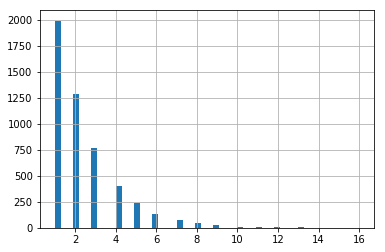

In [140]:
truth['amount_count_rank'].hist(bins = 50)

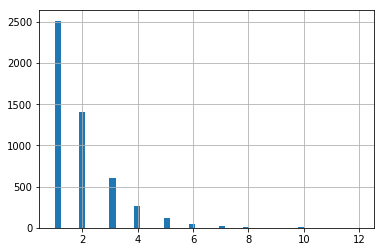

In [142]:
truth['amount_mean_rank'].hist(bins = 50)

In [90]:
drop_cols = ['pos_address_lat_mean', 'pos_address_lon_mean', 'home_add_lat_mean', 'home_add_lon_mean']
t = tr.drop(drop_cols, axis=1)
t.head()

,customer_id,clust_label,amount_mean,amount_amax,amount_amin,amount_count,amount_std,dist_home_sq,is_home,rank
1,0001f322716470bf9bfc1708f06f00fc,0,2.553616,2.973381,2.347082,7,0.233241,165.411979,0,3
2,0001f322716470bf9bfc1708f06f00fc,1,3.016776,3.460175,2.407830,3,0.545355,0.003803,0,1
3,0001f322716470bf9bfc1708f06f00fc,2,2.203973,2.394246,1.949756,7,0.160099,0.005140,0,2
5,0007297d86e14bd68bd87b1dbdefe302,0,2.834341,3.596210,0.816582,40,0.560534,0.000164,1,1
6,0007297d86e14bd68bd87b1dbdefe302,1,2.820427,3.401110,2.359619,3,0.530993,0.019297,0,2


In [91]:
t

,customer_id,clust_label,amount_mean,amount_amax,amount_amin,amount_count,amount_std,dist_home_sq,is_home,rank
1,0001f322716470bf9bfc1708f06f00fc,0,2.553616,2.973381,2.347082,7,0.233241,165.411979,0,3
2,0001f322716470bf9bfc1708f06f00fc,1,3.016776,3.460175,2.407830,3,0.545355,0.003803,0,1
3,0001f322716470bf9bfc1708f06f00fc,2,2.203973,2.394246,1.949756,7,0.160099,0.005140,0,2
5,0007297d86e14bd68bd87b1dbdefe302,0,2.834341,3.596210,0.816582,40,0.560534,0.000164,1,1
6,0007297d86e14bd68bd87b1dbdefe302,1,2.820427,3.401110,2.359619,3,0.530993,0.019297,0,2
7,0007297d86e14bd68bd87b1dbdefe302,2,1.830931,2.290534,1.483227,3,0.415123,0.025243,0,4
8,0007297d86e14bd68bd87b1dbdefe302,3,2.425873,3.211002,1.936728,19,0.429054,0.025016,0,3
11,000b709c6c6fb1e8efcfd95e57c2a9de,0,1.665275,1.678664,1.651886,2,0.018935,10.444162,0,2
12,000b709c6c6fb1e8efcfd95e57c2a9de,1,3.459745,3.482396,3.437094,2,0.032033,0.010485,0,1
15,0027a7618d97cc9fbda55fac457eaeb7,0,2.876298,3.224442,2.209947,5,0.387541,0.138240,0,3


In [86]:
features = ['amount_mean', 'amount_amax', 'amount_amin', 'amount_count', 'amount_std']
X = tr[features]
y = tr['is_home']

In [87]:
X.shape

(25059, 5)

### Обучение и тестирование

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Подбор гиперпараметров для DBSCAN

In [ ]:
eps_list = np.logspace(-2, -1, 5)
min_samples_list = [5, 10, 15, 20, 25, 30]

res = {}

for min_samples in min_samples_list:
    for eps in eps_list: 
        res_df = get_dbscan_score(customer_gr, {'leaf_size':5, 'eps': eps, 'min_samples': min_samples})
        score = res_df.query('dist < @r2').shape[0]
        print(f'{eps}, {min_samples}, {score}')
        res.update({(eps, min_samples,):score})

In [ ]:
eps_list = np.logspace(-3, -1, 10)
min_samples_list = [1, 2, 3, 4, 5]

res = {}

for min_samples in min_samples_list:
    for eps in eps_list: 
        res_df = get_dbscan_score(customer_gr, {'leaf_size':5, 'eps': eps, 'min_samples': min_samples})
        score = res_df.query('dist < @r2').shape[0]
        print(f'{eps}, {min_samples}, {score}')
        res.update({(eps, min_samples,):score})

Наилучшие результаты получены при eps = 0.036, min_samples = 1

In [ ]:
train_pr = get_dbscan_score(train_gr, best_dbscan_params)

In [ ]:
train_pr.head()

In [ ]:
train_pr.clust_amount.hist(bins = 100)
plt.xlim([0, 20])

Теперь оценим реальный скор, который я могу выбить

In [ ]:
0.5* train_pr.query('dist <= @r2').shape[0]/train_pr.shape[0]

На борде скор 0.206375

In [ ]:
test_pr = get_dbscan_score(test_gr, best_dbscan_params, calc_dist= False)
test_pr.head()

In [ ]:
submit = test_pr.loc[:,['home_post_lat', 'home_post_lon', 'best_post_lat',  'best_post_lon']]
submit.head()

In [ ]:
submit.columns = ['best_post_lat', 'best_post_lon',  'home_post_lat', 'home_post_lon', 'dist', 'clust_size']

In [ ]:
submit.to_csv('1.csv')